# Imputation Research Project <img src="https://miro.medium.com/max/1400/1*JPZcoAD9kERfEQxwlaPT-A.jpeg" alt="Alt text image not displaying" width="500" align="right" />
## Notebook 1.1: Exploratory Data Analysis

**Author:** Chike Odenigbo

**Date:** November 25th, 2022

**Notebook Structure:**

* 1.0 Preprocessing

* **1.1 Exploratory Data Analysis**

* 1.2 Masking

* 2.* Models


Water Sugar lutein_zeaxanthin Alcohol

In [1]:
# DOCUMENTATION: https://rianneschouten.github.io/pyampute/build/html/pyampute.ampute.html
# https://bookdown.org/rwnahhas/RMPH/mi-mechanisms.html
# https://stats.stackexchange.com/questions/462507/how-to-decide-whether-missing-values-are-mar-mcar-or-mnar
from pyampute.ampute import MultivariateAmputation
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
import itertools
import pandas as pd
import os
from src.visualization.visualize import histogram, box_plot, bar_plot
from pathlib import Path
from notebook_config import ROOT_DIR # setup.py file changed the root of the project so it is set in the config file
ROOT_DIR = ROOT_DIR.as_posix() # convert root path to windows readable path (i.e. change backslash to forward slash)
import numpy as np
import random
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
# warnings.filterwarnings('ignore', category=FutureWarning)
import pickle
from joblib import load, dump
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
notebook_nm = '2.1-masking'
fig_dir = f'{ROOT_DIR}/reports/figures/'
output_prefix = notebook_nm

In [3]:
# nutrition_df.drop(['name','serving_size'],axis='columns')
def ampute(df, target_col, mechanism, prop = 0.2, seed = 1): 
    ma = MultivariateAmputation(prop = prop, patterns = [{'incomplete_vars':[target_col] ,'mechanism':mechanism}],verbose = False, seed = seed)
    output_df = ma.fit_transform(df)
    return output_df

In [4]:
pd.set_option('display.max_columns', None)
nutrition_df = pd.read_csv(f'{ROOT_DIR}/data/interim/nutrition_numerical.csv').dropna(axis = 'rows')#.reset_index(drop = True)
nutrient_stats_df = pd.read_csv(f'{ROOT_DIR}/data/interim/nutrition_facts_statistics.csv')
nutrient_stats_df
# ma = MultivariateAmputation(prop = 0.2, patterns = [{'incomplete_vars':['water'] ,'mechanism':'MCAR'}],verbose = True)
# na_water_df = ma.fit_transform(nutrition_df.drop(['name','serving_size'],axis='columns'))
# na_water_df

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value
0,alcohol,8715,8789,1.964985,0.991580,74,13.615567,0.000000,0.00,1
1,galactose,8602,8789,1.922415,0.978723,187,16.214746,0.000000,0.00,1
2,theobromine,8545,8789,1.900942,0.972238,244,12.982805,0.000000,0.00,1
3,caffeine,8488,8789,1.879468,0.965753,301,31.458645,0.000000,0.00,1
4,lactose,8390,8789,1.842549,0.954602,399,13.917778,0.000000,0.00,1
...,...,...,...,...,...,...,...,...,...,...
68,protein,358,8789,-1.183318,0.040733,49,0.928165,0.000000,8.02,3
69,sodium,355,8789,-1.184448,0.040391,473,3.065803,0.000000,84.00,3
70,water,96,8789,-1.282020,0.010923,0,0.568690,0.000000,63.08,3
71,serving_size,0,8789,-1.318186,0.000000,0,0.000000,0.000000,100.00,3


In [5]:
random.seed(30)
param_grid = {
    'prop':[0.1,0.2,0.3],
#     'score_to_probability_func':['sigmoid-right', 'sigmoid-left'],
    'columns':nutrition_df.drop(['name','serving_size'],axis='columns').columns.values
}
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
# params = random.sample(permutations_dicts, 60)
# params

In [6]:
len(permutations_dicts)

216

In [7]:
result_cols = ['column','prop_na','mcar_test_mcar','mnar_test_mnar','mar_test_mar']
df = pd.DataFrame(columns=result_cols)
impute_test_df = [df]
for param in permutations_dicts:
    try:
    #     mechanism = param['mechanism']
        prop = param['prop']
        col = param['columns']
        print(param)
        mcar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MCAR', prop = prop, seed = 20)
        mnar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MNAR', prop = prop, seed = 20)
        mar_df = ampute(nutrition_df.drop(['name','serving_size'],axis='columns'), col, mechanism = 'MAR', prop = prop, seed = 20)
        mcar_p_val = mt.little_mcar_test(mcar_df)
        mnar_p_val = mt.little_mcar_test(mnar_df)
        mar_p_val = mt.little_mcar_test(mar_df)
    #     print(f'MCAR Test {col} mcar: {mcar_p_val}')
    #     print(f'MCAR Test {col} mnar: {mnar_p_val}')
    #     print(f'MCAR Test {col} mar: {mar_p_val}')
        data = pd.DataFrame([[col,prop, mcar_p_val, mnar_p_val ,mar_p_val]], columns=result_cols)
        # store DataFrame in list
        impute_test_df.append(data)
    except:
        continue
# see pd.concat documentation for more info
impute_test_df = pd.concat(impute_test_df)
impute_test_df

2022-11-27 19:03:40,196 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:40,350 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'total_fat'}


2022-11-27 19:03:40,455 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:40,662 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:40,723 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:40,819 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.1, 'columns': 'saturated_fat'}


2022-11-27 19:03:41,003 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:41,070 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:41,155 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'cholesterol'}


2022-11-27 19:03:41,366 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:41,454 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:41,537 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'sodium'}


2022-11-27 19:03:41,716 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:41,805 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:41,870 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'choline'}


2022-11-27 19:03:42,066 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:42,137 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:42,218 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'folate'}


2022-11-27 19:03:42,431 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:42,500 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:42,585 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'folic_acid'}


2022-11-27 19:03:42,749 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:42,820 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:42,902 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'niacin'}


2022-11-27 19:03:43,083 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:43,153 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:43,234 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'pantothenic_acid'}


2022-11-27 19:03:43,417 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:43,503 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:43,586 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'riboflavin'}


2022-11-27 19:03:43,749 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:43,818 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:43,903 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'thiamin'}


2022-11-27 19:03:44,067 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:44,152 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:44,234 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_a'}


2022-11-27 19:03:44,413 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:44,485 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:44,568 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_a_rae'}


2022-11-27 19:03:44,733 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:44,800 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:44,901 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'carotene_alpha'}


2022-11-27 19:03:45,082 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:45,150 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:45,235 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'carotene_beta'}


2022-11-27 19:03:45,429 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:45,501 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:45,583 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'cryptoxanthin_beta'}


2022-11-27 19:03:45,763 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:45,835 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:45,915 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'lutein_zeaxanthin'}


2022-11-27 19:03:46,082 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:46,165 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:46,233 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_b12'}


2022-11-27 19:03:46,427 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:46,501 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:46,584 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_b6'}


2022-11-27 19:03:46,748 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:46,834 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:46,914 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_c'}


2022-11-27 19:03:47,079 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:47,148 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:47,233 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_d'}


2022-11-27 19:03:47,411 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:47,482 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:47,584 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_e'}


2022-11-27 19:03:47,778 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:47,847 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:47,916 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'tocopherol_alpha'}


2022-11-27 19:03:48,095 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:48,166 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:48,249 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'vitamin_k'}


2022-11-27 19:03:48,429 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:48,497 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:48,582 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'calcium'}


2022-11-27 19:03:48,776 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:48,850 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:48,930 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'copper'}


2022-11-27 19:03:49,110 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:49,181 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:49,279 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'irom'}


2022-11-27 19:03:49,458 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:49,530 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:49,630 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'magnesium'}


2022-11-27 19:03:49,808 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:49,880 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:49,962 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'manganese'}


2022-11-27 19:03:50,143 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:50,213 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:50,295 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'phosphorous'}


2022-11-27 19:03:50,460 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:50,544 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:50,629 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'potassium'}


2022-11-27 19:03:50,807 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:50,864 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:50,962 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'selenium'}


2022-11-27 19:03:51,142 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:51,243 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:51,328 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'zink'}


2022-11-27 19:03:51,490 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:51,562 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:51,644 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'protein'}


2022-11-27 19:03:51,823 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:51,896 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:51,993 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'alanine'}


2022-11-27 19:03:52,158 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:52,228 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:52,337 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'arginine'}


2022-11-27 19:03:52,492 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:52,562 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:52,659 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'aspartic_acid'}


2022-11-27 19:03:52,824 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:52,893 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:52,991 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'cystine'}


2022-11-27 19:03:53,171 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:53,244 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:53,326 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'glutamic_acid'}


2022-11-27 19:03:53,506 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:53,577 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:53,644 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'glycine'}


2022-11-27 19:03:53,825 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:53,894 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:53,977 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'histidine'}


2022-11-27 19:03:54,157 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:54,226 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:54,310 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'hydroxyproline'}


2022-11-27 19:03:54,489 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:54,558 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:54,643 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'isoleucine'}


2022-11-27 19:03:54,806 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:54,876 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:54,976 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'leucine'}


2022-11-27 19:03:55,137 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:55,209 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:55,275 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'lysine'}


2022-11-27 19:03:55,457 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:55,543 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:55,624 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'methionine'}


2022-11-27 19:03:55,805 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:55,874 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:55,941 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'phenylalanine'}


2022-11-27 19:03:56,137 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:56,223 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:56,306 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'proline'}


2022-11-27 19:03:56,502 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:56,574 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:56,657 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'serine'}


2022-11-27 19:03:56,821 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:56,924 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:57,006 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'threonine'}


2022-11-27 19:03:57,201 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:57,275 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:57,340 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'tryptophan'}


2022-11-27 19:03:57,522 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:57,610 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:57,689 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'tyrosine'}


2022-11-27 19:03:57,884 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:57,957 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:58,038 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'valine'}


2022-11-27 19:03:58,220 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:58,306 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:58,388 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'carbohydrate'}


2022-11-27 19:03:58,599 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:58,673 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:58,755 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'fiber'}


2022-11-27 19:03:58,935 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:59,006 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:59,087 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'sugars'}


2022-11-27 19:03:59,270 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:59,339 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:59,421 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'fructose'}


2022-11-27 19:03:59,617 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:59,690 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:03:59,772 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'galactose'}


2022-11-27 19:03:59,936 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:00,037 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:00,120 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'glucose'}


2022-11-27 19:04:00,314 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:00,388 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:00,471 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'lactose'}


2022-11-27 19:04:00,635 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:00,703 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:00,786 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'maltose'}


2022-11-27 19:04:00,965 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:01,038 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:01,119 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'sucrose'}


2022-11-27 19:04:01,315 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:01,387 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:01,468 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'fat'}


2022-11-27 19:04:01,666 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:01,737 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:01,819 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'saturated_fatty_acids'}


2022-11-27 19:04:01,982 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:02,055 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:02,152 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'monounsaturated_fatty_acids'}


2022-11-27 19:04:02,330 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:02,402 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:02,486 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'polyunsaturated_fatty_acids'}


2022-11-27 19:04:02,694 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:02,751 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:02,836 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'fatty_acids_total_trans'}


2022-11-27 19:04:03,014 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:03,103 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:03,183 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'alcohol'}


2022-11-27 19:04:03,365 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:03,450 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:03,532 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'ash'}


2022-11-27 19:04:03,713 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:03,785 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:03,884 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'caffeine'}


2022-11-27 19:04:04,064 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:04,149 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:04,249 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'theobromine'}


2022-11-27 19:04:04,460 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:04,550 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:04,618 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.1, 'columns': 'water'}


2022-11-27 19:04:04,813 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:04,884 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:04,965 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'total_fat'}


2022-11-27 19:04:05,131 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:05,217 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:05,299 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'saturated_fat'}


2022-11-27 19:04:05,477 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:05,565 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:05,650 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'cholesterol'}


2022-11-27 19:04:05,827 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:05,900 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:05,997 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'sodium'}


2022-11-27 19:04:06,171 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:06,247 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:06,332 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'choline'}


2022-11-27 19:04:06,527 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:06,599 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:06,683 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'folate'}


2022-11-27 19:04:06,847 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:06,931 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:07,015 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'folic_acid'}


2022-11-27 19:04:07,210 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:07,281 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:07,379 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'niacin'}


2022-11-27 19:04:07,560 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:07,616 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:07,714 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'pantothenic_acid'}


2022-11-27 19:04:07,911 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:07,981 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:08,065 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'riboflavin'}


2022-11-27 19:04:08,260 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:08,346 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:08,444 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'thiamin'}


2022-11-27 19:04:08,625 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:08,696 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:08,781 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_a'}


2022-11-27 19:04:08,961 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:09,048 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:09,128 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_a_rae'}


2022-11-27 19:04:09,325 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:09,410 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:09,495 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'carotene_alpha'}


2022-11-27 19:04:09,706 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:09,795 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:09,878 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'carotene_beta'}


2022-11-27 19:04:10,074 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:10,129 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:10,228 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'cryptoxanthin_beta'}


2022-11-27 19:04:10,408 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:10,496 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:10,577 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'lutein_zeaxanthin'}


2022-11-27 19:04:10,756 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:10,844 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:10,911 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_b12'}


2022-11-27 19:04:11,090 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:11,161 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:11,260 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_b6'}


2022-11-27 19:04:11,441 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:11,527 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:11,609 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_c'}


2022-11-27 19:04:11,789 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:11,893 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:11,977 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_d'}


2022-11-27 19:04:12,139 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:12,212 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:12,293 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_e'}


2022-11-27 19:04:12,491 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:12,561 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:12,658 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'tocopherol_alpha'}


2022-11-27 19:04:12,839 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:12,910 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:12,992 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'vitamin_k'}


2022-11-27 19:04:13,155 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:13,226 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:13,310 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'calcium'}


2022-11-27 19:04:13,506 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:13,594 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:13,675 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'copper'}


2022-11-27 19:04:13,869 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:13,957 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:14,041 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'irom'}


2022-11-27 19:04:14,221 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:14,276 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:14,358 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'magnesium'}


2022-11-27 19:04:14,538 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:14,623 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:14,724 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'manganese'}


2022-11-27 19:04:14,903 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:14,960 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:15,057 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'phosphorous'}


2022-11-27 19:04:15,238 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:15,324 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:15,406 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'potassium'}


2022-11-27 19:04:15,601 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:15,675 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:15,772 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'selenium'}


2022-11-27 19:04:15,969 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:16,058 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:16,156 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'zink'}


2022-11-27 19:04:16,352 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:16,424 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:16,523 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'protein'}


2022-11-27 19:04:16,702 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:16,774 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:16,856 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'alanine'}


2022-11-27 19:04:17,052 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:17,138 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:17,206 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'arginine'}


2022-11-27 19:04:17,400 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:17,489 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:17,572 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'aspartic_acid'}


2022-11-27 19:04:17,766 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:17,840 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:17,920 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'cystine'}


2022-11-27 19:04:18,103 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:18,189 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:18,270 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'glutamic_acid'}


2022-11-27 19:04:18,466 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:18,556 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:18,637 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'glycine'}


2022-11-27 19:04:18,816 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:18,903 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:18,987 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'histidine'}


2022-11-27 19:04:19,181 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:19,254 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:19,339 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'hydroxyproline'}


2022-11-27 19:04:19,534 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:19,619 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:19,704 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'isoleucine'}


2022-11-27 19:04:19,897 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:20,001 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'leucine'}


2022-11-27 19:04:20,101 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:20,281 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:20,353 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:20,434 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.2, 'columns': 'lysine'}


2022-11-27 19:04:20,619 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:20,701 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:20,784 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'methionine'}


2022-11-27 19:04:20,949 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:21,036 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:21,119 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'phenylalanine'}


2022-11-27 19:04:21,298 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:21,370 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:21,452 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'proline'}


2022-11-27 19:04:21,664 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:21,736 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:21,833 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'serine'}


2022-11-27 19:04:22,012 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:22,101 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:22,201 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'threonine'}


2022-11-27 19:04:22,380 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:22,482 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:22,566 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'tryptophan'}


2022-11-27 19:04:22,759 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:22,835 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:22,917 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'tyrosine'}


2022-11-27 19:04:23,098 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:23,184 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:23,284 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'valine'}


2022-11-27 19:04:23,492 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:23,568 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:23,666 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'carbohydrate'}


2022-11-27 19:04:23,845 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:23,932 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:24,017 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'fiber'}


2022-11-27 19:04:24,226 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:24,301 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:24,383 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'sugars'}


2022-11-27 19:04:24,578 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:24,667 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:24,750 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'fructose'}


2022-11-27 19:04:24,943 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:25,016 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:25,114 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'galactose'}


2022-11-27 19:04:25,292 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:25,366 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:25,447 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'glucose'}


2022-11-27 19:04:25,644 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:25,715 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:25,815 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'lactose'}


2022-11-27 19:04:26,010 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:26,098 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:26,180 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'maltose'}


2022-11-27 19:04:26,375 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:26,464 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:26,546 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'sucrose'}


2022-11-27 19:04:26,740 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:26,814 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:26,898 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'fat'}


2022-11-27 19:04:27,108 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:27,195 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:27,263 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'saturated_fatty_acids'}


2022-11-27 19:04:27,459 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:27,531 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:27,629 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'monounsaturated_fatty_acids'}


2022-11-27 19:04:27,809 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:27,895 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:27,979 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'polyunsaturated_fatty_acids'}


2022-11-27 19:04:28,192 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:28,264 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:28,347 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'fatty_acids_total_trans'}


2022-11-27 19:04:28,542 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:28,614 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:28,695 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'alcohol'}


2022-11-27 19:04:28,883 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:28,979 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:29,076 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'ash'}


2022-11-27 19:04:29,256 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:29,346 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:29,426 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'caffeine'}


2022-11-27 19:04:29,608 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:29,696 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:29,778 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'theobromine'}


2022-11-27 19:04:29,959 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:30,045 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:30,112 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.2, 'columns': 'water'}


2022-11-27 19:04:30,307 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:30,394 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:30,478 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'total_fat'}


2022-11-27 19:04:30,673 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:30,745 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:30,826 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'saturated_fat'}


2022-11-27 19:04:31,022 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:31,094 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:31,160 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'cholesterol'}


2022-11-27 19:04:31,358 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:31,428 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:31,523 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'sodium'}


2022-11-27 19:04:31,721 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:31,808 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:31,892 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'choline'}


2022-11-27 19:04:32,087 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:32,176 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:32,260 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'folate'}


2022-11-27 19:04:32,469 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:32,557 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:32,642 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'folic_acid'}


2022-11-27 19:04:32,822 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:32,907 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:33,008 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'niacin'}


2022-11-27 19:04:33,202 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:33,291 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:33,357 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'pantothenic_acid'}


2022-11-27 19:04:33,568 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:33,643 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:33,726 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'riboflavin'}


2022-11-27 19:04:33,920 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:34,023 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:34,124 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'thiamin'}


2022-11-27 19:04:34,341 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:34,410 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:34,522 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_a'}


2022-11-27 19:04:34,718 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:34,792 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:34,875 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_a_rae'}


2022-11-27 19:04:35,084 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:35,158 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:35,255 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'carotene_alpha'}


2022-11-27 19:04:35,452 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:35,523 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:35,613 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'carotene_beta'}


2022-11-27 19:04:35,817 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:35,888 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:35,973 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'cryptoxanthin_beta'}


2022-11-27 19:04:36,180 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:36,255 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:36,354 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'lutein_zeaxanthin'}


2022-11-27 19:04:36,533 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:36,622 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:36,705 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_b12'}


2022-11-27 19:04:36,885 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:36,957 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:37,055 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_b6'}


2022-11-27 19:04:37,249 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:37,323 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:37,406 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_c'}


2022-11-27 19:04:37,601 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:37,687 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:37,770 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_d'}


2022-11-27 19:04:37,965 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:38,039 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:38,135 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_e'}


2022-11-27 19:04:38,330 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:38,403 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:38,502 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'tocopherol_alpha'}


2022-11-27 19:04:38,683 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:38,756 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:38,838 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'vitamin_k'}


2022-11-27 19:04:39,034 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:39,121 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:39,203 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'calcium'}


2022-11-27 19:04:39,382 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:39,469 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:39,552 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'copper'}


2022-11-27 19:04:39,763 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:39,851 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:39,936 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'irom'}


2022-11-27 19:04:40,130 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:40,203 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:40,301 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'magnesium'}


2022-11-27 19:04:40,480 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:40,552 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:40,652 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'manganese'}


2022-11-27 19:04:40,861 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:40,921 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:41,017 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'phosphorous'}


2022-11-27 19:04:41,229 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:41,303 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:41,402 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'potassium'}


2022-11-27 19:04:41,580 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:41,668 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:41,751 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'selenium'}


2022-11-27 19:04:41,931 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:42,001 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:42,116 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'zink'}


2022-11-27 19:04:42,359 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:42,434 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:42,533 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'protein'}


2022-11-27 19:04:42,744 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:42,817 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:42,900 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'alanine'}


2022-11-27 19:04:43,111 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:43,184 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:43,297 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'arginine'}


2022-11-27 19:04:43,478 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:43,565 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:43,664 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'aspartic_acid'}


2022-11-27 19:04:43,892 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:43,967 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:44,066 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'cystine'}


2022-11-27 19:04:44,290 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:44,396 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:44,465 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'glutamic_acid'}


2022-11-27 19:04:44,675 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:44,750 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:44,832 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'glycine'}


2022-11-27 19:04:45,044 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:45,115 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:45,199 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'histidine'}


2022-11-27 19:04:45,394 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:45,480 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:45,562 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'hydroxyproline'}


2022-11-27 19:04:45,758 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:45,832 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:45,913 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'isoleucine'}


2022-11-27 19:04:46,125 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:46,213 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:46,296 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'leucine'}


2022-11-27 19:04:46,492 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:46,565 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:46,646 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'lysine'}


2022-11-27 19:04:46,826 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:46,914 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:46,997 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'methionine'}


2022-11-27 19:04:47,207 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:47,296 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:47,379 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'phenylalanine'}


2022-11-27 19:04:47,573 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:47,677 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:47,760 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'proline'}


2022-11-27 19:04:47,942 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:48,012 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:48,096 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'serine'}


2022-11-27 19:04:48,313 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:48,407 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'threonine'}


2022-11-27 19:04:48,524 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:48,712 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:48,796 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:48,877 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'tryptophan'}


2022-11-27 19:04:49,056 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:49,164 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:49,243 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'tyrosine'}


2022-11-27 19:04:49,485 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:49,547 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:49,643 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'valine'}


2022-11-27 19:04:49,824 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:49,909 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:49,979 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'carbohydrate'}


2022-11-27 19:04:50,205 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:50,308 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:50,393 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'fiber'}


2022-11-27 19:04:50,591 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:50,676 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:50,760 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'sugars'}


2022-11-27 19:04:50,925 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:51,012 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:51,094 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'fructose'}


2022-11-27 19:04:51,286 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:51,360 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:51,442 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'galactose'}


2022-11-27 19:04:51,621 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:51,708 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:51,791 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'glucose'}


2022-11-27 19:04:51,970 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:52,074 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'lactose'}


2022-11-27 19:04:52,205 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:52,447 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:52,525 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:52,625 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'maltose'}


2022-11-27 19:04:52,834 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:52,909 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:53,008 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'sucrose'}


2022-11-27 19:04:53,296 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:53,406 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'fat'}


2022-11-27 19:04:53,538 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:53,801 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:53,896 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:53,992 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'saturated_fatty_acids'}


2022-11-27 19:04:54,243 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:54,352 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:54,453 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'monounsaturated_fatty_acids'}


2022-11-27 19:04:54,701 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:54,805 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:54,907 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'polyunsaturated_fatty_acids'}


2022-11-27 19:04:55,142 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:55,246 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'fatty_acids_total_trans'}


2022-11-27 19:04:55,359 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:55,592 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:55,680 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:55,780 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'alcohol'}


2022-11-27 19:04:56,040 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:56,141 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'ash'}


2022-11-27 19:04:56,248 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:56,483 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:56,572 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:56,676 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is

{'prop': 0.3, 'columns': 'caffeine'}


2022-11-27 19:04:56,889 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:56,991 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:57,102 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'theobromine'}


2022-11-27 19:04:57,341 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:04:57,455 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


{'prop': 0.3, 'columns': 'water'}


2022-11-27 19:04:57,581 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


,column,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar


In [8]:
# impute_test_df = pd.concat(impute_test_df)
impute_test_df

,column,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar


In [9]:
nutrient_impute_test_df = pd.merge(nutrient_stats_df, impute_test_df, left_on='nutrient', right_on='column').drop('column',axis = 'columns')
nutrient_impute_test_df

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar


In [10]:
nutrient_impute_test_df[nutrient_impute_test_df.nutrient == 'water']#.nlargest(50,'outlier_count')

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar


Image found in the "reports/figures" folder saved under 2.1-masking-water-var-sel_mask_variable_selection_tertile_3_zero_value:_water_distribution_water_hist.png


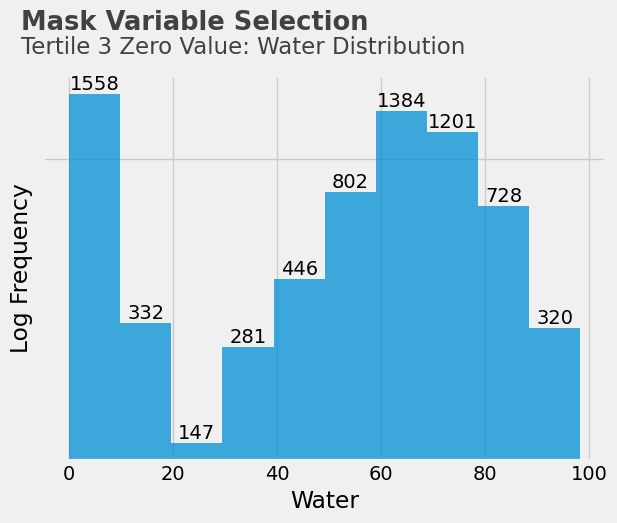

In [11]:
histogram(df = nutrition_df, col = 'water',output_prefix = f'{notebook_nm}-water-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Water Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-sugars-var-sel_mask_variable_selection_tertile_2_zero_value:_sugars_distribution_sugars_hist.png


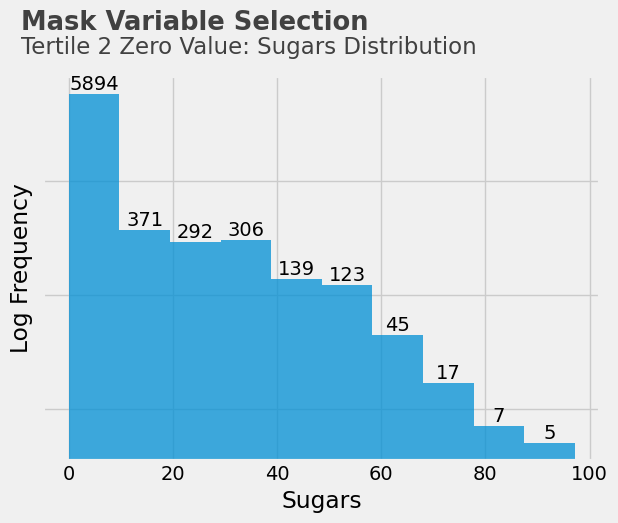

In [12]:
histogram(df = nutrition_df, col = 'sugars',output_prefix = f'{notebook_nm}-sugars-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Sugars Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-vitamin_c-var-sel_mask_variable_selection_tertile_2_zero_value:_vitamin_c_distribution_vitamin_c_hist.png


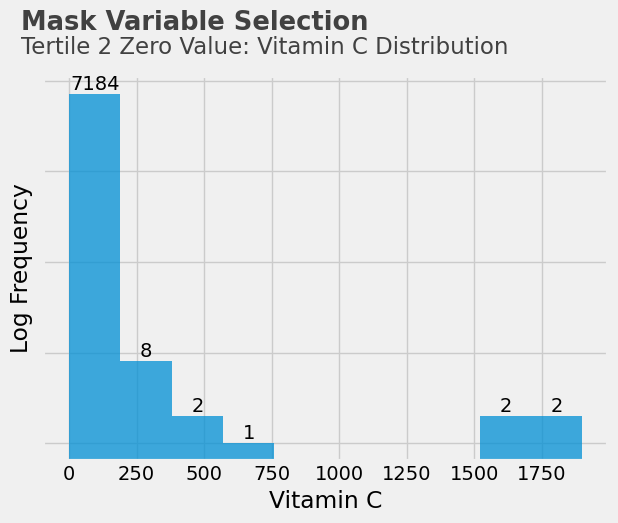

In [13]:
histogram(df = nutrition_df, col = 'vitamin_c',output_prefix = f'{notebook_nm}-vitamin_c-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Vitamin C Distribution', bins = 10, log_scale = True)

In [14]:
nutrient_impute_test_df[nutrient_impute_test_df.tertile_zero_value == 1].nlargest(50,'outlier_count')

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar


In [15]:
nutrient_impute_test_df[nutrient_impute_test_df.tertile_zero_value == 2].nlargest(50,'outlier_count')

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar


In [16]:
nutrient_impute_test_df[nutrient_impute_test_df.tertile_zero_value == 3].nlargest(50,'outlier_count')

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value,prop_na,mcar_test_mcar,mnar_test_mnar,mar_test_mar


In [17]:
nutrition_df['lutein_zeaxanthin'].describe()

count     7199.000000
mean        99.719822
std        847.378557
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      19697.000000
Name: lutein_zeaxanthin, dtype: float64

Image found in the "reports/figures" folder saved under 2.1-masking-magnesium-var-sel_mask_variable_selection_tertile_3_zero_value:_magnesium_distribution_magnesium_hist.png


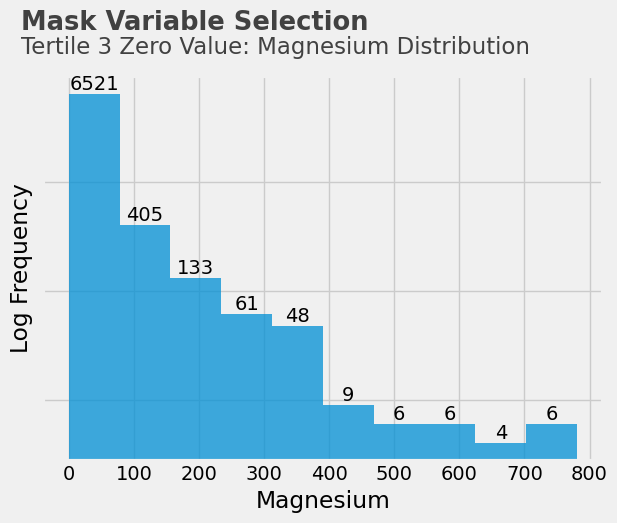

In [18]:
histogram(df = nutrition_df, col = 'magnesium',output_prefix = f'{notebook_nm}-magnesium-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Magnesium Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-vitamin_d-var-sel_mask_variable_selection_tertile_1_zero_value:_vitamin_d_distribution_vitamin_d_hist.png


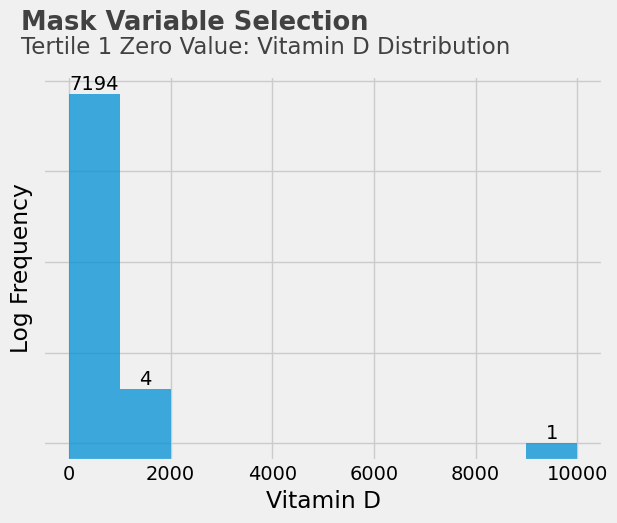

In [19]:
histogram(df = nutrition_df, col = 'vitamin_d',output_prefix = f'{notebook_nm}-vitamin_d-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Vitamin D Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 2.1-masking-lutein_zeaxanthin-var-sel_mask_variable_selection_tertile_1_zero_value:_lutein_zeaxanthin_distribution_lutein_zeaxanthin_hist.png


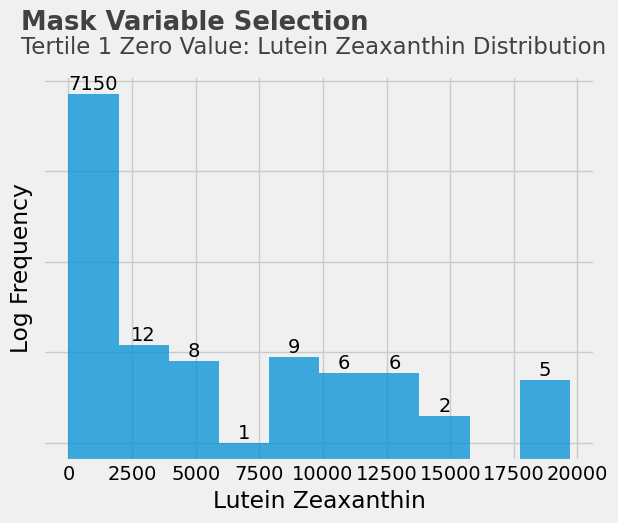

In [20]:
histogram(df = nutrition_df, col = 'lutein_zeaxanthin',output_prefix = f'{notebook_nm}-lutein_zeaxanthin-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Lutein Zeaxanthin Distribution', bins = 10, log_scale = True)

In [21]:
mt = MCARTest(method="little")

In [22]:
lutein_mcar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'lutein_zeaxanthin', mechanism = 'MCAR', prop = 0.3, seed = 20)
ma = MultivariateAmputation(prop = 0.2, patterns = [{'incomplete_vars':['lutein_zeaxanthin'] ,'mechanism':'MAR', 'score_to_probability_func':'sigmoid-tail'}],verbose = True, seed = 20)
lutein_mar_df = ma.fit_transform(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'))

mt.little_mcar_test(lutein_mar_df)

2022-11-27 19:05:02,138 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:05:02,216 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


0.0

In [23]:
water_mcar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'water', mechanism = 'MCAR', prop = 0.2, seed = 20)
water_mar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'water', mechanism = 'MAR', prop = 0.1, seed = 20)
mt.little_mcar_test(water_mar_df)

2022-11-27 19:05:02,621 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:05:02,699 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


0.0

In [24]:
sugars_mcar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'sugars', mechanism = 'MCAR', prop = 0.3, seed = 20)
sugars_mar_df = ampute(nutrition_df.set_index('name').drop(['serving_size'],axis='columns'), 'sugars', mechanism = 'MAR', prop = 0.1, seed = 20)
mt.little_mcar_test(water_mar_df)

2022-11-27 19:05:03,050 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.
2022-11-27 19:05:03,135 [WARNING] Failed to load lookup table for a prespecified score to probability function. It is possible data\shift_lookup.csv is missing, in the wrong location, or corrupted. Try rerunning scripts/generate_shift_lookup_table.py to regenerate the lookup table.


0.0

In [25]:
mt.little_mcar_test(lutein_mar_df)

0.0

In [26]:
full_targets_df = nutrition_df.set_index('name')[['water','sugars','lutein_zeaxanthin']]
lutein_df = nutrition_df.set_index('name').drop('lutein_zeaxanthin', axis = 'columns').join(lutein_mcar_df[['lutein_zeaxanthin']].join(lutein_mar_df[['lutein_zeaxanthin']],lsuffix = '_mcar',rsuffix = '_mar').join(full_targets_df['lutein_zeaxanthin'],rsuffix = '_complete'))
lutein_df#.isnull().sum()#[['lutein_zeaxanthin_missing','lutein_zeaxanthin_complete']]

,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water,lutein_zeaxanthin_mcar,lutein_zeaxanthin_mar,lutein_zeaxanthin
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Nuts, pecans",100,72.0,6.2,0,0.0,40.5,22.0,0.0,1.167,0.863,0.130,0.660,56.0,3.0,0.0,29.0,9.0,0.00,0.210,1.1,0.0,1.40,1.40,3.5,70.0,1.200,2.53,121.0,4.500,277.0,410.0,3.8,4.53,9.17,0.397,1.177,0.929,0.152,1.829,0.453,0.262,0.000,0.336,0.598,0.287,0.183,0.426,0.363,0.474,0.306,0.093,0.215,0.411,13.86,9.6,3.97,0.04,0.0,0.04,0.0,0.00,3.90,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52,17.0,17.0,17.0
"Teff, uncooked",100,2.4,0.4,0,12.0,13.1,0.0,0.0,3.363,0.942,0.270,0.390,9.0,0.0,0.0,5.0,0.0,0.00,0.482,0.0,0.0,0.08,0.08,1.9,180.0,0.810,7.63,184.0,9.240,429.0,427.0,4.4,3.63,13.30,0.747,0.517,0.820,0.236,3.349,0.477,0.301,0.000,0.501,1.068,0.376,0.428,0.698,0.664,0.622,0.510,0.139,0.458,0.686,73.13,8.0,1.84,0.47,0.0,0.73,0.0,0.01,0.62,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82,NaN,NaN,66.0
"Sherbet, orange",100,2.0,1.2,1,46.0,7.7,4.0,0.0,0.063,0.224,0.097,0.027,46.0,12.0,0.0,1.0,5.0,0.13,0.023,2.3,0.0,0.01,0.01,0.0,54.0,0.028,0.14,8.0,0.011,40.0,96.0,1.5,0.48,1.10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,30.40,1.3,24.32,0.00,0.0,0.00,0.0,0.00,0.00,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10,NaN,NaN,7.0
"Cauliflower, raw",100,0.3,0.1,0,30.0,44.3,57.0,0.0,0.507,0.667,0.060,0.050,0.0,0.0,0.0,0.0,0.0,0.00,0.184,48.2,0.0,0.08,0.08,15.5,22.0,0.039,0.42,15.0,0.155,44.0,299.0,0.6,0.27,1.92,0.116,0.086,0.177,0.020,0.257,0.071,0.056,0.000,0.071,0.106,0.217,0.020,0.065,0.071,0.086,0.076,0.020,0.051,0.125,4.97,2.0,1.91,0.97,0.0,0.94,0.0,0.00,0.00,0.28,0.130,0.034,0.031,0.0,0.0,0.76,0.0,0.0,92.07,NaN,NaN,1.0
"Taro leaves, raw",100,0.7,0.2,0,3.0,12.8,126.0,0.0,1.513,0.084,0.456,0.209,4825.0,241.0,0.0,2895.0,0.0,0.00,0.146,52.0,0.0,2.02,2.02,108.6,107.0,0.270,2.25,45.0,0.714,60.0,648.0,0.9,0.41,4.98,0.000,0.220,0.000,0.064,0.000,0.000,0.114,0.000,0.260,0.392,0.246,0.079,0.195,0.000,0.000,0.167,0.048,0.178,0.256,6.70,3.7,3.01,0.00,0.0,0.00,0.0,0.00,0.00,0.74,0.151,0.060,0.307,0.0,0.0,1.92,0.0,0.0,85.66,1932.0,1932.0,1932.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Beef, raw, all grades, trimmed to 0"" fat, separable lean and fat, boneless, top round roast, round",100,3.5,1.4,62,54.0,64.5,4.0,0.0,6.422,0.356,0.234,0.063,11.0,3.0,0.0,0.0,0.0,1.64,0.631,0.0,1.0,0.23,0.23,1.5,13.0,0.048,2.33,12.0,0.004,219.0,311.0,22.1,3.67,23.45,1.454,1.597,2.285,0.239,3.834,1.154,0.879,0.160,1.092,2.021,2.246,0.635,0.941,1.052,0.966,1.105,0.262,0.874,1.172,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51,0.0,0.0,0.0
"Lamb, cooked, separable lean only, composite of trimmed retail cuts, frozen, imported, New Zealand",100,8.9,3.9,109,50.0,0.0,0.0,0.0,7.680,0.580,0.500,0.130,0.0,0.0,0.0,0.0,0.0,2.95,0.140,0.0,0.0,0.19,0.19,0.0,13.0,0.114,2.35,22.0,0.029,246.0,188.0,2.0,4.30,29.59,1.7

In [27]:
sugars_df = nutrition_df.set_index('name').drop('sugars', axis = 'columns').join(sugars_mcar_df[['sugars']].join(sugars_mar_df[['sugars']],lsuffix = '_mcar',rsuffix = '_mar').join(full_targets_df['sugars'],rsuffix = '_complete'))
sugars_df.isnull().sum().nlargest(3)

sugars_mcar     2251
sugars_mar       704
serving_size       0
dtype: int64

In [28]:
water_df = nutrition_df.set_index('name').drop('water', axis = 'columns').join(water_mcar_df[['water']].join(water_mar_df[['water']],lsuffix = '_mcar',rsuffix = '_mar').join(full_targets_df['water'],rsuffix = '_complete'))
water_df.isnull().sum().nlargest(3)

water_mcar      1476
water_mar        706
serving_size       0
dtype: int64

In [29]:
water_df.to_csv(f'{ROOT_DIR}/data/processed/water.csv', index=True)
sugars_df.to_csv(f'{ROOT_DIR}/data/processed/sugars.csv', index=True)
lutein_df.to_csv(f'{ROOT_DIR}/data/processed/lutein.csv', index=True)

In [30]:
water_df

,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water_mcar,water_mar,water
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Nuts, pecans",100,72.0,6.2,0,0.0,40.5,22.0,0.0,1.167,0.863,0.130,0.660,56.0,3.0,0.0,29.0,9.0,17.0,0.00,0.210,1.1,0.0,1.40,1.40,3.5,70.0,1.200,2.53,121.0,4.500,277.0,410.0,3.8,4.53,9.17,0.397,1.177,0.929,0.152,1.829,0.453,0.262,0.000,0.336,0.598,0.287,0.183,0.426,0.363,0.474,0.306,0.093,0.215,0.411,13.86,9.6,3.97,0.04,0.0,0.04,0.0,0.00,3.90,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52,3.52,3.52
"Teff, uncooked",100,2.4,0.4,0,12.0,13.1,0.0,0.0,3.363,0.942,0.270,0.390,9.0,0.0,0.0,5.0,0.0,66.0,0.00,0.482,0.0,0.0,0.08,0.08,1.9,180.0,0.810,7.63,184.0,9.240,429.0,427.0,4.4,3.63,13.30,0.747,0.517,0.820,0.236,3.349,0.477,0.301,0.000,0.501,1.068,0.376,0.428,0.698,0.664,0.622,0.510,0.139,0.458,0.686,73.13,8.0,1.84,0.47,0.0,0.73,0.0,0.01,0.62,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,NaN,8.82,8.82
"Sherbet, orange",100,2.0,1.2,1,46.0,7.7,4.0,0.0,0.063,0.224,0.097,0.027,46.0,12.0,0.0,1.0,5.0,7.0,0.13,0.023,2.3,0.0,0.01,0.01,0.0,54.0,0.028,0.14,8.0,0.011,40.0,96.0,1.5,0.48,1.10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,30.40,1.3,24.32,0.00,0.0,0.00,0.0,0.00,0.00,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,NaN,66.10,66.10
"Cauliflower, raw",100,0.3,0.1,0,30.0,44.3,57.0,0.0,0.507,0.667,0.060,0.050,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.184,48.2,0.0,0.08,0.08,15.5,22.0,0.039,0.42,15.0,0.155,44.0,299.0,0.6,0.27,1.92,0.116,0.086,0.177,0.020,0.257,0.071,0.056,0.000,0.071,0.106,0.217,0.020,0.065,0.071,0.086,0.076,0.020,0.051,0.125,4.97,2.0,1.91,0.97,0.0,0.94,0.0,0.00,0.00,0.28,0.130,0.034,0.031,0.0,0.0,0.76,0.0,0.0,NaN,92.07,92.07
"Taro leaves, raw",100,0.7,0.2,0,3.0,12.8,126.0,0.0,1.513,0.084,0.456,0.209,4825.0,241.0,0.0,2895.0,0.0,1932.0,0.00,0.146,52.0,0.0,2.02,2.02,108.6,107.0,0.270,2.25,45.0,0.714,60.0,648.0,0.9,0.41,4.98,0.000,0.220,0.000,0.064,0.000,0.000,0.114,0.000,0.260,0.392,0.246,0.079,0.195,0.000,0.000,0.167,0.048,0.178,0.256,6.70,3.7,3.01,0.00,0.0,0.00,0.0,0.00,0.00,0.74,0.151,0.060,0.307,0.0,0.0,1.92,0.0,0.0,85.66,85.66,85.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Beef, raw, all grades, trimmed to 0"" fat, separable lean and fat, boneless, top round roast, round",100,3.5,1.4,62,54.0,64.5,4.0,0.0,6.422,0.356,0.234,0.063,11.0,3.0,0.0,0.0,0.0,0.0,1.64,0.631,0.0,1.0,0.23,0.23,1.5,13.0,0.048,2.33,12.0,0.004,219.0,311.0,22.1,3.67,23.45,1.454,1.597,2.285,0.239,3.834,1.154,0.879,0.160,1.092,2.021,2.246,0.635,0.941,1.052,0.966,1.105,0.262,0.874,1.172,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51,72.51,72.51
"Lamb, cooked, separable lean only, composite of trimmed retail cuts, frozen, imported, New Zealand",100,8.9,3.9,109,50.0,0.0,0.0,0.0,7.680,0.580,0.500,0.130,0.0,0.0,0.0,0.0,0.0,0.0,2.95,0.140,0.0,0.0,0.19,0.19,0.0,13.0,0.114,2.35,22.0,0.029,246.0,188.0,2.0,4.30,29.59,1.780,1.758,2.60

In [31]:
scaler_water_mar = StandardScaler()
water_mar_df = water_df
water_mar_df['dataset_type'] = np.where(water_mar_df['water_mar'].isnull(),'validation','training')
water_mar_df = water_mar_df.reset_index().set_index(['dataset_type','name']).drop(['water_mcar','water'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
water_mar_scaled_df = scaler_water_mar.fit_transform(water_mar_df)
water_mar_scaled_df = water_mar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(water_mar_scaled_df,columns = water_mar_df.columns))
water_mar_scaled_df#.head(50)

,name,dataset_type,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water_mar
0,"Nuts, pecans",training,0.0,3.596307,0.291893,-0.366113,-0.435551,0.228384,-0.209526,-0.198124,-0.598476,0.235663,-0.329650,0.875784,-0.151787,-0.116302,-0.06443,-0.077065,0.039505,-0.097625,-0.312098,-0.176382,-0.096600,-0.125774,0.091222,0.091222,-0.080784,-0.047544,1.717884,-0.076167,1.442291,0.626420,0.574706,0.415869,-0.376594,0.631948,-0.397119,-0.271142,0.627573,0.017739,0.191368,0.047029,-0.112145,-0.164825,-0.367017,-0.253714,-0.253840,-0.543016,-0.253487,-0.025040,-0.283553,0.073584,-0.258726,-0.157730,-0.349888,-0.193107,-0.330509,1.660769,-0.194171,-0.121733,-0.062457,-0.114107,-0.07869,-0.173220,0.973011,3.595641,0.289465,4.968632,3.479097,-0.366113,-0.024432,-0.140161,-0.032626,-0.083373,-1.561722
1,"Teff, uncooked",training,0.0,-0.619342,-0.551556,-0.366113,-0.419401,-0.264566,-0.377104,-0.198124,-0.121463,0.295053,0.016684,0.315431,-0.165265,-0.119859,-0.06443,-0.101149,-0.039304,-0.039796,-0.312098,0.387865,-0.120460,-0.125774,-0.224649,-0.224649,-0.106650,0.565155,1.057292,0.776284,2.507023,1.367768,1.442629,0.469791,-0.355989,0.378058,0.005471,0.247723,-0.195034,-0.083019,0.785573,0.862210,-0.076787,-0.062212,-0.367017,0.059323,0.257674,-0.452719,0.554252,0.543382,0.213058,0.379865,0.157415,0.193964,0.252622,0.283687,1.776759,1.304084,-0.352894,0.311358,-0.062457,0.372412,-0.07869,-0.150615,0.023213,-0.620268,-0.544198,-0.549419,-0.273112,-0.366113,-0.024432,0.265352,-0.032626,-0.083373,-1.383044
2,"Sherbet, orange",training,0.0,-0.643570,-0.435218,-0.358304,-0.373641,-0.361717,-0.346635,-0.198124,-0.838286,-0.244720,-0.411286,-0.437932,-0.154655,-0.105630,-0.06443,-0.105163,0.004479,-0.109427,-0.283870,-0.564302,-0.070570,-0.125774,-0.241400,-0.241400,-0.137364,-0.136664,-0.267279,-0.475648,-0.467465,-0.075670,-0.778567,-0.580093,-0.455583,-0.510558,-1.183777,-0.859682,-0.839409,-0.841020,-0.883861,-0.933870,-0.779530,-0.854175,-0.367017,-0.891171,-0.904661,-0.834197,-0.856819,-0.915290,-0.882456,-0.907343,-0.882938,-0.868764,-0.882973,-0.905697,0.257549,-0.189534,1.322267,-0.162020,-0.062457,-0.142311,-0.07869,-0.173220,-0.156322,-0.643289,-0.440772,-0.557515,-0.454119,-0.358304,-0.024432,-0.642443,-0.032626,-0.083373,0.548031
3,"Cauliflower, raw",training,0.0,-0.746538,-0.595182,-0.366113,-0.395175,0.296750,0.057075,-0.198124,-0.741841,0.088316,-0.502818,-0.390198,-0.167846,-0.119859,-0.06443,-0.106167,-0.039304,-0.116508,-0.312098,-0.230317,0.925066,-0.125774,-0.224649,-0.224649,0.113204,-0.314904,-0.248647,-0.428847,-0.349161,-0.053148,-0.755727,0.063794,-0.486491,-0.569799,-1.103844,-0.687716,-0.732221,-0.677402,-0.742383,-0.796040,-0.674929,-0.706833,-0.367017,-0.756470,-0.789298,-0.614036,-0.790881,-0.779454,-0.765315,-0.729369,-0.727905,-0.715853,-0.756520,-0.688973,-0.646582,-0.033484,-0.347678,0.814953,-0.062457,0.520483,-0.07869,-0.173220,-0.156322,-0.747491,-0.590602,-0.625578,-0.463069,-0.366113,-0.024432,-0.476551,-0.032626,-0.083373,1.423555
4,"Taro leaves, raw",training,0.0,-0.722310,-0.580640,-0.366113,-0.431514,-0.269964,0.582661,-0.198124,-0.523319,-0.349968,0.476815,-0.060213,1.215804,0.165906,-0.06443,2.799010,-0.039304,2.162443,-0.312098,-0.309146,1.007493,-0.125774,0.239586,0.239586,1.

In [32]:
scaler_water_mcar = StandardScaler()
water_mcar_df = water_df
water_mcar_df['dataset_type'] = np.where(water_mcar_df['water_mcar'].isnull(),'validation','training')
water_mcar_df = water_mcar_df.reset_index().set_index(['dataset_type','name']).drop(['water_mar','water'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
water_mcar_scaled_df = scaler_water_mcar.fit_transform(water_mcar_df)
water_mcar_scaled_df = water_mcar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(water_mcar_scaled_df,columns = water_mcar_df.columns))
water_mcar_scaled_df.head(50)

,name,dataset_type,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water_mcar
0,"Nuts, pecans",training,0.0,3.596307,0.291893,-0.366113,-0.435551,0.228384,-0.209526,-0.198124,-0.598476,0.235663,-0.329650,0.875784,-0.151787,-0.116302,-0.064430,-0.077065,0.039505,-0.097625,-0.312098,-0.176382,-0.096600,-0.125774,0.091222,0.091222,-0.080784,-0.047544,1.717884,-0.076167,1.442291,0.626420,0.574706,0.415869,-0.376594,0.631948,-0.397119,-0.271142,0.627573,0.017739,0.191368,0.047029,-0.112145,-0.164825,-0.367017,-0.253714,-0.253840,-0.543016,-0.253487,-0.025040,-0.283553,0.073584,-0.258726,-0.157730,-0.349888,-0.193107,-0.330509,1.660769,-0.194171,-0.121733,-0.062457,-0.114107,-0.078690,-0.173220,0.973011,3.595641,0.289465,4.968632,3.479097,-0.366113,-0.024432,-0.140161,-0.032626,-0.083373,-1.540787
1,"Teff, uncooked",validation,0.0,-0.619342,-0.551556,-0.366113,-0.419401,-0.264566,-0.377104,-0.198124,-0.121463,0.295053,0.016684,0.315431,-0.165265,-0.119859,-0.064430,-0.101149,-0.039304,-0.039796,-0.312098,0.387865,-0.120460,-0.125774,-0.224649,-0.224649,-0.106650,0.565155,1.057292,0.776284,2.507023,1.367768,1.442629,0.469791,-0.355989,0.378058,0.005471,0.247723,-0.195034,-0.083019,0.785573,0.862210,-0.076787,-0.062212,-0.367017,0.059323,0.257674,-0.452719,0.554252,0.543382,0.213058,0.379865,0.157415,0.193964,0.252622,0.283687,1.776759,1.304084,-0.352894,0.311358,-0.062457,0.372412,-0.078690,-0.150615,0.023213,-0.620268,-0.544198,-0.549419,-0.273112,-0.366113,-0.024432,0.265352,-0.032626,-0.083373,NaN
2,"Sherbet, orange",validation,0.0,-0.643570,-0.435218,-0.358304,-0.373641,-0.361717,-0.346635,-0.198124,-0.838286,-0.244720,-0.411286,-0.437932,-0.154655,-0.105630,-0.064430,-0.105163,0.004479,-0.109427,-0.283870,-0.564302,-0.070570,-0.125774,-0.241400,-0.241400,-0.137364,-0.136664,-0.267279,-0.475648,-0.467465,-0.075670,-0.778567,-0.580093,-0.455583,-0.510558,-1.183777,-0.859682,-0.839409,-0.841020,-0.883861,-0.933870,-0.779530,-0.854175,-0.367017,-0.891171,-0.904661,-0.834197,-0.856819,-0.915290,-0.882456,-0.907343,-0.882938,-0.868764,-0.882973,-0.905697,0.257549,-0.189534,1.322267,-0.162020,-0.062457,-0.142311,-0.078690,-0.173220,-0.156322,-0.643289,-0.440772,-0.557515,-0.454119,-0.358304,-0.024432,-0.642443,-0.032626,-0.083373,NaN
3,"Cauliflower, raw",validation,0.0,-0.746538,-0.595182,-0.366113,-0.395175,0.296750,0.057075,-0.198124,-0.741841,0.088316,-0.502818,-0.390198,-0.167846,-0.119859,-0.064430,-0.106167,-0.039304,-0.116508,-0.312098,-0.230317,0.925066,-0.125774,-0.224649,-0.224649,0.113204,-0.314904,-0.248647,-0.428847,-0.349161,-0.053148,-0.755727,0.063794,-0.486491,-0.569799,-1.103844,-0.687716,-0.732221,-0.677402,-0.742383,-0.796040,-0.674929,-0.706833,-0.367017,-0.756470,-0.789298,-0.614036,-0.790881,-0.779454,-0.765315,-0.729369,-0.727905,-0.715853,-0.756520,-0.688973,-0.646582,-0.033484,-0.347678,0.814953,-0.062457,0.520483,-0.078690,-0.173220,-0.156322,-0.747491,-0.590602,-0.625578,-0.463069,-0.366113,-0.024432,-0.476551,-0.032626,-0.083373,NaN
4,"Taro leaves, raw",training,0.0,-0.722310,-0.580640,-0.366113,-0.431514,-0.269964,0.582661,-0.198124,-0.523319,-0.349968,0.476815,-0.060213,1.215804,0.165906,-0.064430,2.799010,-0.039304,2.162443,-0.312098,-0.309146,1.007493,-0.125774,0.239586,0.239586,1.

In [33]:
scaler_sugars_mcar = StandardScaler()
sugars_mcar_df = sugars_df
sugars_mcar_df['dataset_type'] = np.where(sugars_mcar_df['sugars_mcar'].isnull(),'validation','training')
sugars_mcar_df = sugars_mcar_df.reset_index().set_index(['dataset_type','name']).drop(['sugars_mar','sugars'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
sugars_mcar_scaled_df = scaler_sugars_mcar.fit_transform(sugars_mcar_df)
sugars_mcar_scaled_df = sugars_mcar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(sugars_mcar_scaled_df,columns = sugars_mcar_df.columns))
sugars_mcar_scaled_df.head(50)

,name,dataset_type,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water,sugars_mcar
0,"Nuts, pecans",training,0.0,3.596307,0.291893,-0.366113,-0.435551,0.228384,-0.209526,-0.198124,-0.598476,0.235663,-0.329650,0.875784,-0.151787,-0.116302,-0.064430,-0.077065,0.039505,-0.097625,-0.312098,-0.176382,-0.096600,-0.125774,0.091222,0.091222,-0.080784,-0.047544,1.717884,-0.076167,1.442291,0.626420,0.574706,0.415869,-0.376594,0.631948,-0.397119,-0.271142,0.627573,0.017739,0.191368,0.047029,-0.112145,-0.164825,-0.367017,-0.253714,-0.253840,-0.543016,-0.253487,-0.025040,-0.283553,0.073584,-0.258726,-0.157730,-0.349888,-0.193107,-0.330509,1.660769,-0.121733,-0.062457,-0.114107,-0.078690,-0.173220,0.973011,3.595641,0.289465,4.968632,3.479097,-0.366113,-0.024432,-0.140161,-0.032626,-0.083373,-1.541401,-0.189090
1,"Teff, uncooked",validation,0.0,-0.619342,-0.551556,-0.366113,-0.419401,-0.264566,-0.377104,-0.198124,-0.121463,0.295053,0.016684,0.315431,-0.165265,-0.119859,-0.064430,-0.101149,-0.039304,-0.039796,-0.312098,0.387865,-0.120460,-0.125774,-0.224649,-0.224649,-0.106650,0.565155,1.057292,0.776284,2.507023,1.367768,1.442629,0.469791,-0.355989,0.378058,0.005471,0.247723,-0.195034,-0.083019,0.785573,0.862210,-0.076787,-0.062212,-0.367017,0.059323,0.257674,-0.452719,0.554252,0.543382,0.213058,0.379865,0.157415,0.193964,0.252622,0.283687,1.776759,1.304084,0.311358,-0.062457,0.372412,-0.078690,-0.150615,0.023213,-0.620268,-0.544198,-0.549419,-0.273112,-0.366113,-0.024432,0.265352,-0.032626,-0.083373,-1.362369,NaN
2,"Sherbet, orange",validation,0.0,-0.643570,-0.435218,-0.358304,-0.373641,-0.361717,-0.346635,-0.198124,-0.838286,-0.244720,-0.411286,-0.437932,-0.154655,-0.105630,-0.064430,-0.105163,0.004479,-0.109427,-0.283870,-0.564302,-0.070570,-0.125774,-0.241400,-0.241400,-0.137364,-0.136664,-0.267279,-0.475648,-0.467465,-0.075670,-0.778567,-0.580093,-0.455583,-0.510558,-1.183777,-0.859682,-0.839409,-0.841020,-0.883861,-0.933870,-0.779530,-0.854175,-0.367017,-0.891171,-0.904661,-0.834197,-0.856819,-0.915290,-0.882456,-0.907343,-0.882938,-0.868764,-0.882973,-0.905697,0.257549,-0.189534,-0.162020,-0.062457,-0.142311,-0.078690,-0.173220,-0.156322,-0.643289,-0.440772,-0.557515,-0.454119,-0.358304,-0.024432,-0.642443,-0.032626,-0.083373,0.572518,NaN
3,"Cauliflower, raw",validation,0.0,-0.746538,-0.595182,-0.366113,-0.395175,0.296750,0.057075,-0.198124,-0.741841,0.088316,-0.502818,-0.390198,-0.167846,-0.119859,-0.064430,-0.106167,-0.039304,-0.116508,-0.312098,-0.230317,0.925066,-0.125774,-0.224649,-0.224649,0.113204,-0.314904,-0.248647,-0.428847,-0.349161,-0.053148,-0.755727,0.063794,-0.486491,-0.569799,-1.103844,-0.687716,-0.732221,-0.677402,-0.742383,-0.796040,-0.674929,-0.706833,-0.367017,-0.756470,-0.789298,-0.614036,-0.790881,-0.779454,-0.765315,-0.729369,-0.727905,-0.715853,-0.756520,-0.688973,-0.646582,-0.033484,0.814953,-0.062457,0.520483,-0.078690,-0.173220,-0.156322,-0.747491,-0.590602,-0.625578,-0.463069,-0.366113,-0.024432,-0.476551,-0.032626,-0.083373,1.449770,NaN
4,"Taro leaves, raw",training,0.0,-0.722310,-0.580640,-0.366113,-0.431514,-0.269964,0.582661,-0.198124,-0.523319,-0.349968,0.476815,-0.060213,1.215804,0.165906,-0.064430,2.799010,-0.039304,2.162443,-0.312098,-0.309146,1.007493,-0.125774,0.239586,0.239586,1.6

In [34]:
scaler_sugars_mar = StandardScaler()
sugars_mar_df = sugars_df
sugars_mar_df['dataset_type'] = np.where(sugars_mar_df['sugars_mar'].isnull(),'validation','training')
sugars_mar_df = sugars_mar_df.reset_index().set_index(['dataset_type','name']).drop(['sugars_mcar','sugars'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
sugars_mar_scaled_df = scaler_sugars_mar.fit_transform(sugars_mar_df)
sugars_mar_scaled_df = sugars_mar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(sugars_mar_scaled_df,columns = sugars_mar_df.columns))
sugars_mar_scaled_df

,name,dataset_type,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water,sugars_mar
0,"Nuts, pecans",training,0.0,3.596307,0.291893,-0.366113,-0.435551,0.228384,-0.209526,-0.198124,-0.598476,0.235663,-0.329650,0.875784,-0.151787,-0.116302,-0.06443,-0.077065,0.039505,-0.097625,-0.312098,-0.176382,-0.096600,-0.125774,0.091222,0.091222,-0.080784,-0.047544,1.717884,-0.076167,1.442291,0.626420,0.574706,0.415869,-0.376594,0.631948,-0.397119,-0.271142,0.627573,0.017739,0.191368,0.047029,-0.112145,-0.164825,-0.367017,-0.253714,-0.253840,-0.543016,-0.253487,-0.025040,-0.283553,0.073584,-0.258726,-0.157730,-0.349888,-0.193107,-0.330509,1.660769,-0.121733,-0.062457,-0.114107,-0.07869,-0.173220,0.973011,3.595641,0.289465,4.968632,3.479097,-0.366113,-0.024432,-0.140161,-0.032626,-0.083373,-1.541401,-0.204942
1,"Teff, uncooked",training,0.0,-0.619342,-0.551556,-0.366113,-0.419401,-0.264566,-0.377104,-0.198124,-0.121463,0.295053,0.016684,0.315431,-0.165265,-0.119859,-0.06443,-0.101149,-0.039304,-0.039796,-0.312098,0.387865,-0.120460,-0.125774,-0.224649,-0.224649,-0.106650,0.565155,1.057292,0.776284,2.507023,1.367768,1.442629,0.469791,-0.355989,0.378058,0.005471,0.247723,-0.195034,-0.083019,0.785573,0.862210,-0.076787,-0.062212,-0.367017,0.059323,0.257674,-0.452719,0.554252,0.543382,0.213058,0.379865,0.157415,0.193964,0.252622,0.283687,1.776759,1.304084,0.311358,-0.062457,0.372412,-0.07869,-0.150615,0.023213,-0.620268,-0.544198,-0.549419,-0.273112,-0.366113,-0.024432,0.265352,-0.032626,-0.083373,-1.362369,-0.362249
2,"Sherbet, orange",training,0.0,-0.643570,-0.435218,-0.358304,-0.373641,-0.361717,-0.346635,-0.198124,-0.838286,-0.244720,-0.411286,-0.437932,-0.154655,-0.105630,-0.06443,-0.105163,0.004479,-0.109427,-0.283870,-0.564302,-0.070570,-0.125774,-0.241400,-0.241400,-0.137364,-0.136664,-0.267279,-0.475648,-0.467465,-0.075670,-0.778567,-0.580093,-0.455583,-0.510558,-1.183777,-0.859682,-0.839409,-0.841020,-0.883861,-0.933870,-0.779530,-0.854175,-0.367017,-0.891171,-0.904661,-0.834197,-0.856819,-0.915290,-0.882456,-0.907343,-0.882938,-0.868764,-0.882973,-0.905697,0.257549,-0.189534,-0.162020,-0.062457,-0.142311,-0.07869,-0.173220,-0.156322,-0.643289,-0.440772,-0.557515,-0.454119,-0.358304,-0.024432,-0.642443,-0.032626,-0.083373,0.572518,1.297971
3,"Cauliflower, raw",training,0.0,-0.746538,-0.595182,-0.366113,-0.395175,0.296750,0.057075,-0.198124,-0.741841,0.088316,-0.502818,-0.390198,-0.167846,-0.119859,-0.06443,-0.106167,-0.039304,-0.116508,-0.312098,-0.230317,0.925066,-0.125774,-0.224649,-0.224649,0.113204,-0.314904,-0.248647,-0.428847,-0.349161,-0.053148,-0.755727,0.063794,-0.486491,-0.569799,-1.103844,-0.687716,-0.732221,-0.677402,-0.742383,-0.796040,-0.674929,-0.706833,-0.367017,-0.756470,-0.789298,-0.614036,-0.790881,-0.779454,-0.765315,-0.729369,-0.727905,-0.715853,-0.756520,-0.688973,-0.646582,-0.033484,0.814953,-0.062457,0.520483,-0.07869,-0.173220,-0.156322,-0.747491,-0.590602,-0.625578,-0.463069,-0.366113,-0.024432,-0.476551,-0.032626,-0.083373,1.449770,-0.357080
4,"Taro leaves, raw",training,0.0,-0.722310,-0.580640,-0.366113,-0.431514,-0.269964,0.582661,-0.198124,-0.523319,-0.349968,0.476815,-0.060213,1.215804,0.165906,-0.06443,2.799010,-0.039304,2.162443,-0.312098,-0.309146,1.007493,-0.125774,0.239586,0.239586,1.

In [35]:
scaler_lutein_mcar = StandardScaler()
lutein_mcar_df = lutein_df
lutein_mcar_df['dataset_type'] = np.where(lutein_mcar_df['lutein_zeaxanthin_mcar'].isnull(),'validation','training')
lutein_mcar_df = lutein_mcar_df.reset_index().set_index(['dataset_type','name']).drop(['lutein_zeaxanthin_mar','lutein_zeaxanthin'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
lutein_mcar_scaled_df = scaler_lutein_mcar.fit_transform(lutein_mcar_df)
lutein_mcar_scaled_df = lutein_mcar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(lutein_mcar_scaled_df,columns = lutein_mcar_df.columns))
lutein_mcar_scaled_df.head(50)

,name,dataset_type,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water,lutein_zeaxanthin_mcar
0,"Nuts, pecans",training,0.0,3.596307,0.291893,-0.366113,-0.435551,0.228384,-0.209526,-0.198124,-0.598476,0.235663,-0.329650,0.875784,-0.151787,-0.116302,-0.064430,-0.077065,0.039505,-0.312098,-0.176382,-0.096600,-0.125774,0.091222,0.091222,-0.080784,-0.047544,1.717884,-0.076167,1.442291,0.626420,0.574706,0.415869,-0.376594,0.631948,-0.397119,-0.271142,0.627573,0.017739,0.191368,0.047029,-0.112145,-0.164825,-0.367017,-0.253714,-0.253840,-0.543016,-0.253487,-0.025040,-0.283553,0.073584,-0.258726,-0.157730,-0.349888,-0.193107,-0.330509,1.660769,-0.194171,-0.121733,-0.062457,-0.114107,-0.078690,-0.173220,0.973011,3.595641,0.289465,4.968632,3.479097,-0.366113,-0.024432,-0.140161,-0.032626,-0.083373,-1.541401,-0.100439
1,"Teff, uncooked",validation,0.0,-0.619342,-0.551556,-0.366113,-0.419401,-0.264566,-0.377104,-0.198124,-0.121463,0.295053,0.016684,0.315431,-0.165265,-0.119859,-0.064430,-0.101149,-0.039304,-0.312098,0.387865,-0.120460,-0.125774,-0.224649,-0.224649,-0.106650,0.565155,1.057292,0.776284,2.507023,1.367768,1.442629,0.469791,-0.355989,0.378058,0.005471,0.247723,-0.195034,-0.083019,0.785573,0.862210,-0.076787,-0.062212,-0.367017,0.059323,0.257674,-0.452719,0.554252,0.543382,0.213058,0.379865,0.157415,0.193964,0.252622,0.283687,1.776759,1.304084,-0.352894,0.311358,-0.062457,0.372412,-0.078690,-0.150615,0.023213,-0.620268,-0.544198,-0.549419,-0.273112,-0.366113,-0.024432,0.265352,-0.032626,-0.083373,-1.362369,NaN
2,"Sherbet, orange",validation,0.0,-0.643570,-0.435218,-0.358304,-0.373641,-0.361717,-0.346635,-0.198124,-0.838286,-0.244720,-0.411286,-0.437932,-0.154655,-0.105630,-0.064430,-0.105163,0.004479,-0.283870,-0.564302,-0.070570,-0.125774,-0.241400,-0.241400,-0.137364,-0.136664,-0.267279,-0.475648,-0.467465,-0.075670,-0.778567,-0.580093,-0.455583,-0.510558,-1.183777,-0.859682,-0.839409,-0.841020,-0.883861,-0.933870,-0.779530,-0.854175,-0.367017,-0.891171,-0.904661,-0.834197,-0.856819,-0.915290,-0.882456,-0.907343,-0.882938,-0.868764,-0.882973,-0.905697,0.257549,-0.189534,1.322267,-0.162020,-0.062457,-0.142311,-0.078690,-0.173220,-0.156322,-0.643289,-0.440772,-0.557515,-0.454119,-0.358304,-0.024432,-0.642443,-0.032626,-0.083373,0.572518,NaN
3,"Cauliflower, raw",validation,0.0,-0.746538,-0.595182,-0.366113,-0.395175,0.296750,0.057075,-0.198124,-0.741841,0.088316,-0.502818,-0.390198,-0.167846,-0.119859,-0.064430,-0.106167,-0.039304,-0.312098,-0.230317,0.925066,-0.125774,-0.224649,-0.224649,0.113204,-0.314904,-0.248647,-0.428847,-0.349161,-0.053148,-0.755727,0.063794,-0.486491,-0.569799,-1.103844,-0.687716,-0.732221,-0.677402,-0.742383,-0.796040,-0.674929,-0.706833,-0.367017,-0.756470,-0.789298,-0.614036,-0.790881,-0.779454,-0.765315,-0.729369,-0.727905,-0.715853,-0.756520,-0.688973,-0.646582,-0.033484,-0.347678,0.814953,-0.062457,0.520483,-0.078690,-0.173220,-0.156322,-0.747491,-0.590602,-0.625578,-0.463069,-0.366113,-0.024432,-0.476551,-0.032626,-0.083373,1.449770,NaN
4,"Taro leaves, raw",training,0.0,-0.722310,-0.580640,-0.366113,-0.431514,-0.269964,0.582661,-0.198124,-0.523319,-0.349968,0.476815,-0.060213,1.215804,0.165906,-0.064430,2.799010,-0.039304,-0.312098,-0.309146,1.007493,-0.125774,0.239586,0.239586,1.618233,0.15

In [41]:
scaler_water_mar.inverse_transform(water_mar_scaled_df.drop(['name','dataset_type'],axis = 'columns'))

array([[100.  ,  72.  ,   6.2 , ...,   0.  ,   0.  ,   3.52],
       [100.  ,   2.4 ,   0.4 , ...,   0.  ,   0.  ,   8.82],
       [100.  ,   2.  ,   1.2 , ...,   0.  ,   0.  ,  66.1 ],
       ...,
       [100.  ,  23.  ,  12.  , ...,   0.  ,   0.  ,  59.8 ],
       [100.  ,   3.  ,   1.1 , ...,   0.  ,   0.  ,  73.43],
       [100.  ,   3.  ,   1.1 , ...,   0.  ,   0.  ,  73.43]])

In [40]:
lutein_mar_df.shape

(7199, 73)

In [36]:
scaler_lutein_mar = StandardScaler()
lutein_mar_df = lutein_df
lutein_mar_df['dataset_type'] = np.where(lutein_mar_df['lutein_zeaxanthin_mar'].isnull(),'validation','training')
lutein_mar_df = lutein_mar_df.reset_index().set_index(['dataset_type','name']).drop(['lutein_zeaxanthin_mcar','lutein_zeaxanthin'],axis = 'columns')#.dropna(axis = 'rows')
# water_mar_df['water_mar'] = water_mar_df['water_mar'].fillna(0)
lutein_mar_scaled_df = scaler_lutein_mar.fit_transform(lutein_mar_df)
lutein_mar_scaled_df = lutein_mar_df.reset_index()[['name','dataset_type']].join(pd.DataFrame(lutein_mar_scaled_df,columns = lutein_mar_df.columns))
lutein_mar_scaled_df.head(50)

,name,dataset_type,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water,lutein_zeaxanthin_mar
0,"Nuts, pecans",training,0.0,3.596307,0.291893,-0.366113,-0.435551,0.228384,-0.209526,-0.198124,-0.598476,0.235663,-0.329650,0.875784,-0.151787,-0.116302,-0.064430,-0.077065,0.039505,-0.312098,-0.176382,-0.096600,-0.125774,0.091222,0.091222,-0.080784,-0.047544,1.717884,-0.076167,1.442291,0.626420,0.574706,0.415869,-0.376594,0.631948,-0.397119,-0.271142,0.627573,0.017739,0.191368,0.047029,-0.112145,-0.164825,-0.367017,-0.253714,-0.253840,-0.543016,-0.253487,-0.025040,-0.283553,0.073584,-0.258726,-0.157730,-0.349888,-0.193107,-0.330509,1.660769,-0.194171,-0.121733,-0.062457,-0.114107,-0.078690,-0.173220,0.973011,3.595641,0.289465,4.968632,3.479097,-0.366113,-0.024432,-0.140161,-0.032626,-0.083373,-1.541401,-0.094711
1,"Teff, uncooked",validation,0.0,-0.619342,-0.551556,-0.366113,-0.419401,-0.264566,-0.377104,-0.198124,-0.121463,0.295053,0.016684,0.315431,-0.165265,-0.119859,-0.064430,-0.101149,-0.039304,-0.312098,0.387865,-0.120460,-0.125774,-0.224649,-0.224649,-0.106650,0.565155,1.057292,0.776284,2.507023,1.367768,1.442629,0.469791,-0.355989,0.378058,0.005471,0.247723,-0.195034,-0.083019,0.785573,0.862210,-0.076787,-0.062212,-0.367017,0.059323,0.257674,-0.452719,0.554252,0.543382,0.213058,0.379865,0.157415,0.193964,0.252622,0.283687,1.776759,1.304084,-0.352894,0.311358,-0.062457,0.372412,-0.078690,-0.150615,0.023213,-0.620268,-0.544198,-0.549419,-0.273112,-0.366113,-0.024432,0.265352,-0.032626,-0.083373,-1.362369,NaN
2,"Sherbet, orange",validation,0.0,-0.643570,-0.435218,-0.358304,-0.373641,-0.361717,-0.346635,-0.198124,-0.838286,-0.244720,-0.411286,-0.437932,-0.154655,-0.105630,-0.064430,-0.105163,0.004479,-0.283870,-0.564302,-0.070570,-0.125774,-0.241400,-0.241400,-0.137364,-0.136664,-0.267279,-0.475648,-0.467465,-0.075670,-0.778567,-0.580093,-0.455583,-0.510558,-1.183777,-0.859682,-0.839409,-0.841020,-0.883861,-0.933870,-0.779530,-0.854175,-0.367017,-0.891171,-0.904661,-0.834197,-0.856819,-0.915290,-0.882456,-0.907343,-0.882938,-0.868764,-0.882973,-0.905697,0.257549,-0.189534,1.322267,-0.162020,-0.062457,-0.142311,-0.078690,-0.173220,-0.156322,-0.643289,-0.440772,-0.557515,-0.454119,-0.358304,-0.024432,-0.642443,-0.032626,-0.083373,0.572518,NaN
3,"Cauliflower, raw",validation,0.0,-0.746538,-0.595182,-0.366113,-0.395175,0.296750,0.057075,-0.198124,-0.741841,0.088316,-0.502818,-0.390198,-0.167846,-0.119859,-0.064430,-0.106167,-0.039304,-0.312098,-0.230317,0.925066,-0.125774,-0.224649,-0.224649,0.113204,-0.314904,-0.248647,-0.428847,-0.349161,-0.053148,-0.755727,0.063794,-0.486491,-0.569799,-1.103844,-0.687716,-0.732221,-0.677402,-0.742383,-0.796040,-0.674929,-0.706833,-0.367017,-0.756470,-0.789298,-0.614036,-0.790881,-0.779454,-0.765315,-0.729369,-0.727905,-0.715853,-0.756520,-0.688973,-0.646582,-0.033484,-0.347678,0.814953,-0.062457,0.520483,-0.078690,-0.173220,-0.156322,-0.747491,-0.590602,-0.625578,-0.463069,-0.366113,-0.024432,-0.476551,-0.032626,-0.083373,1.449770,NaN
4,"Taro leaves, raw",training,0.0,-0.722310,-0.580640,-0.366113,-0.431514,-0.269964,0.582661,-0.198124,-0.523319,-0.349968,0.476815,-0.060213,1.215804,0.165906,-0.064430,2.799010,-0.039304,-0.312098,-0.309146,1.007493,-0.125774,0.239586,0.239586,1.618233,0.158

In [37]:
dump(scaler_lutein_mar, f'{ROOT_DIR}/models/scalers/scaler_lutein_mar.joblib')
lutein_mar_scaled_df.to_csv(f'{ROOT_DIR}/data/processed/lutein_mar_scaled.csv')

dump(scaler_lutein_mcar, f'{ROOT_DIR}/models/scalers/scaler_lutein_mcar.joblib')
lutein_mcar_scaled_df.to_csv(f'{ROOT_DIR}/data/processed/utein_mcar_scaled.csv')

dump(scaler_sugars_mar, f'{ROOT_DIR}/models/scalers/scaler_sugars_mar.joblib')
sugars_mar_scaled_df.to_csv(f'{ROOT_DIR}/data/processed/sugars_mar_scaled.csv')

dump(scaler_sugars_mcar, f'{ROOT_DIR}/models/scalers/scaler_sugars_mcar.joblib')
sugars_mcar_scaled_df.to_csv(f'{ROOT_DIR}/data/processed/sugars_mcar_scaled.csv')

dump(scaler_water_mcar, f'{ROOT_DIR}/models/scalers/scaler_water_mcar.joblib')
water_mcar_scaled_df.to_csv(f'{ROOT_DIR}/data/processed/water_mcar_scaled.csv')

dump(scaler_water_mar, f'{ROOT_DIR}/models/scalers/scaler_water_mar.joblib')
water_mar_scaled_df.to_csv(f'{ROOT_DIR}/data/processed/water_mar_scaled.csv')

In [38]:
nutrient_impute_test_df.to_csv(f'{ROOT_DIR}/data/interim/nutrition_statistics_impute_test_grid_search.csv', index=False)